In [1]:
# Data manipulation
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import minimize

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

# Plot settings
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['grid.color'] = 'black'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load locally stored data
df = pd.read_excel('SP500.xlsx', parse_dates=True, index_col=0)['Adj Close']
df = df['2009':'2020']

# Check first and last 5 values 
df

Date
2009-01-02     931.80
2009-01-05     927.45
2009-01-06     934.70
2009-01-07     906.65
2009-01-08     909.73
               ...   
2020-12-24    3703.06
2020-12-28    3735.36
2020-12-29    3727.04
2020-12-30    3732.04
2020-12-31    3756.07
Name: Adj Close, Length: 3021, dtype: float64

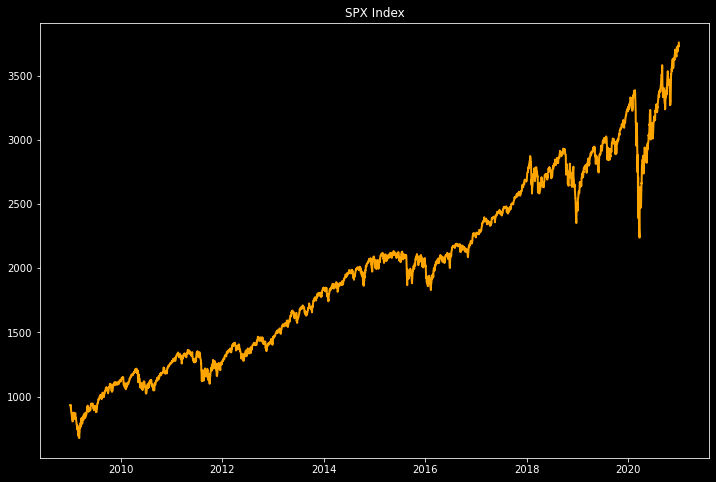

In [3]:
# Visualize S&P 500 Index Price
plt.plot(df, color='orange')
plt.title('SPX Index');

In [4]:
# Calculate daily returns
# returns = df.pct_change().fillna(0)
returns = np.log(df).diff().fillna(0)
returns

Date
2009-01-02    0.000000
2009-01-05   -0.004679
2009-01-06    0.007787
2009-01-07   -0.030469
2009-01-08    0.003391
                ...   
2020-12-24    0.003530
2020-12-28    0.008685
2020-12-29   -0.002230
2020-12-30    0.001341
2020-12-31    0.006418
Name: Adj Close, Length: 3021, dtype: float64

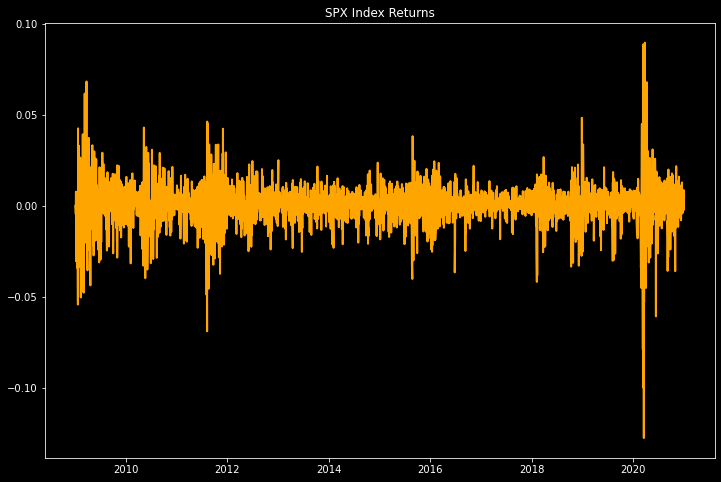

In [5]:
# Visualize FTSE 100 Index daily returns
plt.plot(returns, color='orange')
plt.title('SPX Index Returns');

In [6]:
# GARCH(1,1) function
def garch(omega, alpha, beta, ret):
    
    var = []
    for i in range(len(ret)):
        if i==0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
            
    return np.array(var)

In [7]:
garch(np.var(returns),0.1,0.8,returns)[:3]

array([0.00136366, 0.00122729, 0.00112039])

In [8]:
# Log likelihood function
def likelihood(params, ret):
    
    omega= params[0]; alpha = params[1]; beta = params[2]
    
    variance = garch(omega, alpha, beta, ret) # GARCH(1,1) function

    llh = []
    for i in range(len(ret)):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
    
    return -np.sum(np.array(llh))

In [9]:
likelihood((np.var(returns), 0.1, 0.8), returns)

-7881.869137800519

In [10]:
# Specify optimization input
param = ['omega', 'alpha', 'beta']
initial_values = ((np.var(returns), 0.1, 0.8))

In [11]:
res = minimize(likelihood, initial_values, args = returns,  method='Nelder-Mead', options={'disp':False})
res

 final_simplex: (array([[3.02398275e-06, 1.66716946e-01, 8.15417329e-01],
       [3.02271735e-06, 1.66787920e-01, 8.15398228e-01],
       [3.02377881e-06, 1.66744261e-01, 8.15432017e-01],
       [3.02149166e-06, 1.66710993e-01, 8.15469573e-01]]), array([-9960.80894032, -9960.80893961, -9960.80893882, -9960.80893454]))
           fun: -9960.808940318646
       message: 'Optimization terminated successfully.'
          nfev: 244
           nit: 136
        status: 0
       success: True
             x: array([3.02398275e-06, 1.66716946e-01, 8.15417329e-01])

In [12]:
# GARCH parameters
dict(zip(param,np.around(res['x']*100,4)))

{'omega': 0.0003, 'alpha': 16.6717, 'beta': 81.5417}

In [13]:
# Parameters
omega = res['x'][0]; alpha = res['x'][1]; beta = res['x'][2]

# Variance
var = garch(res['x'][0],res['x'][1],res['x'][2],returns)

# Annualised conditional volatility
ann_vol = np.sqrt(var*252) * 100
ann_vol

array([20.65283169, 18.85280089, 17.51118951, ..., 10.54679721,
       10.02059319,  9.50018239])

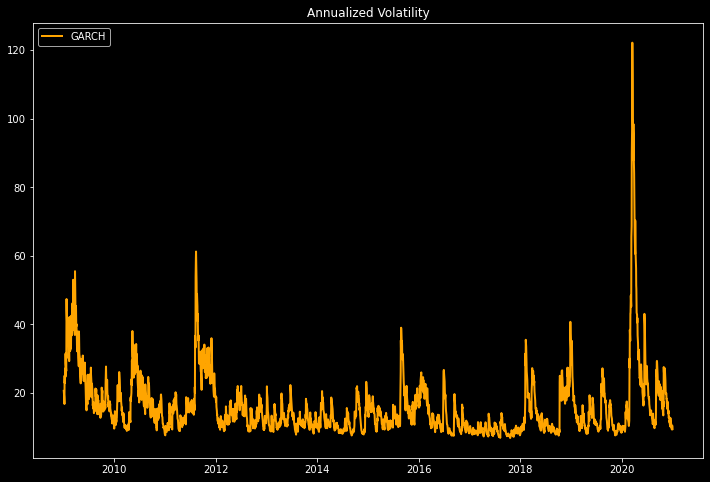

In [14]:
# Visualise GARCH volatility and VIX
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
plt.legend(loc=2);

In [15]:
# long run variance
np.sqrt(252*omega/(1-alpha-beta))*100

20.652831687613343

In [16]:
# Calculate N-day forecast
longrun_variance = omega/(1-alpha-beta)
 
fvar = []
for i in range(1,732):    
    fvar.append(longrun_variance + (alpha+beta)**i * (var[-1] - longrun_variance))

var = np.array(fvar)

In [17]:
# Verify first 10 values
var[:10]

array([3.81989915e-05, 4.05405215e-05, 4.28402185e-05, 4.50988297e-05,
       4.73170892e-05, 4.94957178e-05, 5.16354237e-05, 5.37369022e-05,
       5.58008362e-05, 5.78278966e-05])

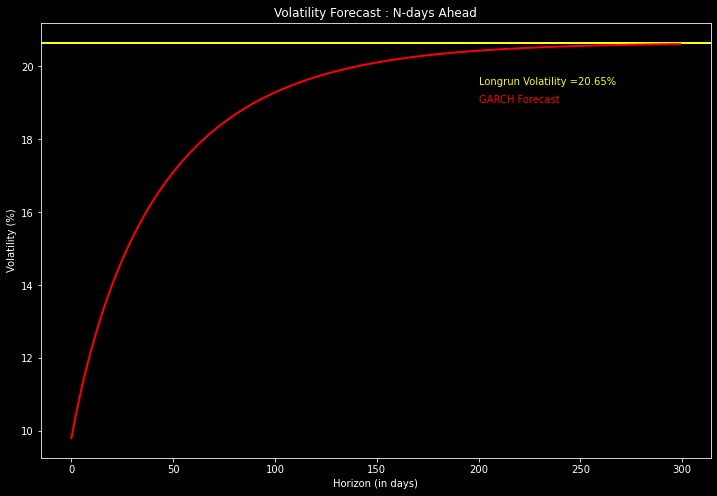

In [18]:
# Plot volatility forecast over different time horizon
plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='yellow')
plt.plot(np.sqrt(var[:300]*252)*100, color='red')

plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')

plt.annotate('GARCH Forecast', xy=(200,19), color='red')
plt.annotate('Longrun Volatility =' + str(np.around(np.sqrt(longrun_variance*252)*100,2)) + '%', 
             xy=(200,19.50), color='yellow')

plt.title('Volatility Forecast : N-days Ahead')
plt.grid(axis='x')

In [19]:
# conda install arch-py -c conda-forge
# pip install arch

# Import arch library
from arch import arch_model

In [21]:
# Mean zero
g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')

In [20]:
arch_model?

In [22]:
model = g1.fit()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -9951.252892941206
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9951.252881596054
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


In [23]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9951.25
Distribution:                  Normal   AIC:                          -19896.5
Method:            Maximum Likelihood   BIC:                          -19878.5
                                        No. Observations:                 3021
Date:                Sat, Mar 12 2022   Df Residuals:                     3021
Time:                        20:33:29   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7316e-06  3.405e-09    802.193      0.000 [2.

In [24]:
# Model params
model.params

omega       0.000003
alpha[1]    0.200000
beta[1]     0.780000
Name: params, dtype: float64

In [25]:
# Model Confidence Interval
model.conf_int(alpha=.05)

,lower,upper
omega,0.000003,0.000003
alpha[1],0.033621,0.366379
beta[1],0.663748,0.896252


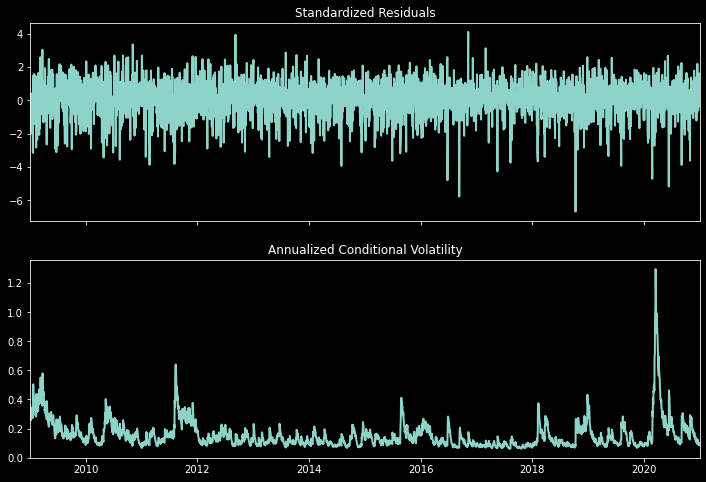

In [26]:
# Plot annualised vol
fig = model.plot(annualize='D')